In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Gerando o sinal e amostrando-o

In [3]:
frequencia = 4 
fs_continuo = 1000 
fs_amostrado = 10 * frequencia 

t_continuo = np.arange(0, 2, 1/fs_continuo)  
t_amostrado = np.arange(0, 2, 1/fs_amostrado) 

ruido_continuo = (np.sin(2 * np.pi * frequencia * t_continuo) + 
                  5 * np.sin(2 * np.pi * 0.4 * frequencia * t_continuo) + 
                  2 * np.sin(2 * np.pi * 0.1 * frequencia * t_continuo))

ruido_amostrado = (np.sin(2 * np.pi * frequencia * t_amostrado) + 
                   5 * np.sin(2 * np.pi * 0.4 * frequencia * t_amostrado) + 
                   2 * np.sin(2 * np.pi * 0.1 * frequencia * t_amostrado))


## Fazendo a interpolação do sinal amostrado por 3:

In [5]:
L = 4

ruido_decimado = np.zeros(len(ruido_amostrado) * (L + 1)) 
ruido_decimado[::(L + 1)] = ruido_amostrado

t_decimado = np.arange(0, 2, 1/(fs_amostrado * (L + 1)))

## Passando os sinais por um filtro FIR :

In [7]:
cutoff_freq = frequencia * 2
numtaps = 101
nyquist_rate_continuo = fs_continuo / 2
nyquist_rate_amostrado = fs_amostrado / 2

filtro_fir_continuo = signal.firwin(numtaps, cutoff_freq / nyquist_rate_continuo)

sinal_filtrado_continuo = signal.lfilter(filtro_fir_continuo, 1.0, ruido_continuo)

filtro_fir_amostrado = signal.firwin(numtaps, cutoff_freq / nyquist_rate_amostrado)

sinal_filtrado_amostrado = signal.lfilter(filtro_fir_amostrado, 1.0, ruido_amostrado)

filtro_fir_decimado = signal.firwin(numtaps, cutoff_freq / (fs_amostrado * (L + 1) / 2))

sinal_filtrado_decimado = signal.lfilter(filtro_fir_decimado, 1.0, ruido_decimado)

## Sinal Contínuo antes e depois do filtro FIR:

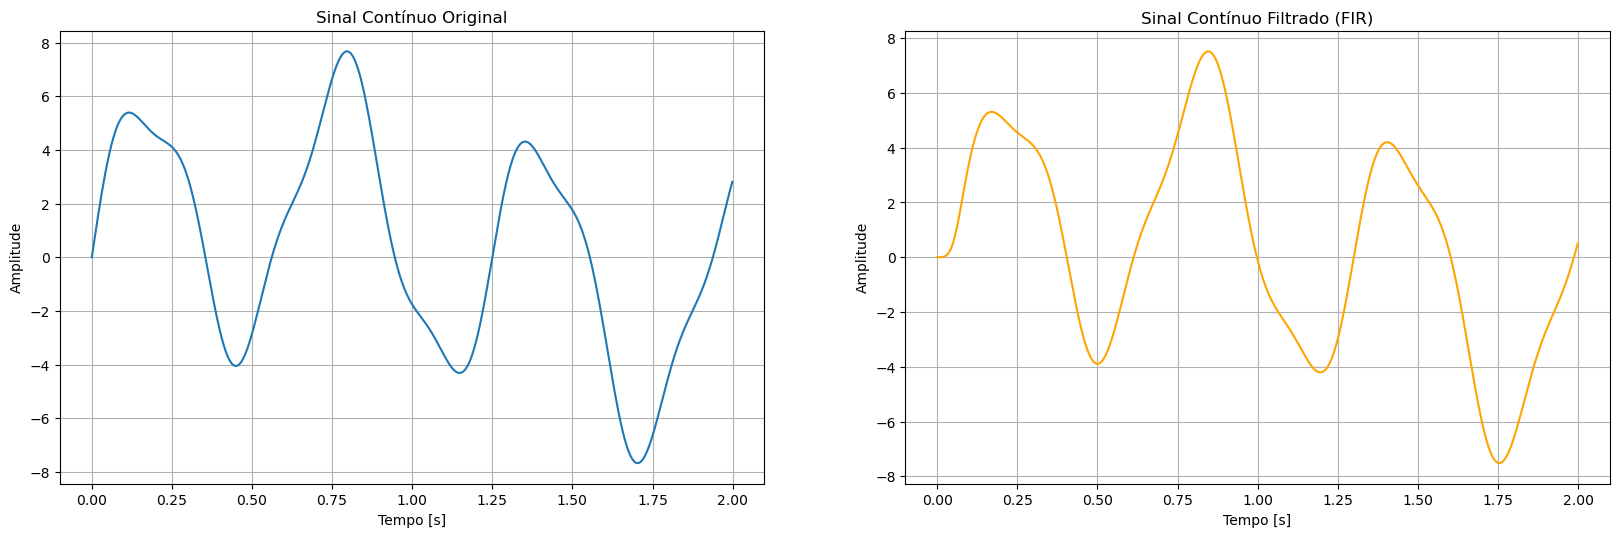

In [9]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
plt.plot(t_continuo, ruido_continuo, label='Original')
plt.title('Sinal Contínuo Original')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(t_continuo, sinal_filtrado_continuo, label='Filtrado', color='orange')
plt.title('Sinal Contínuo Filtrado (FIR)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

## Sinal Amostrado antes e depois do Filtro FIR:

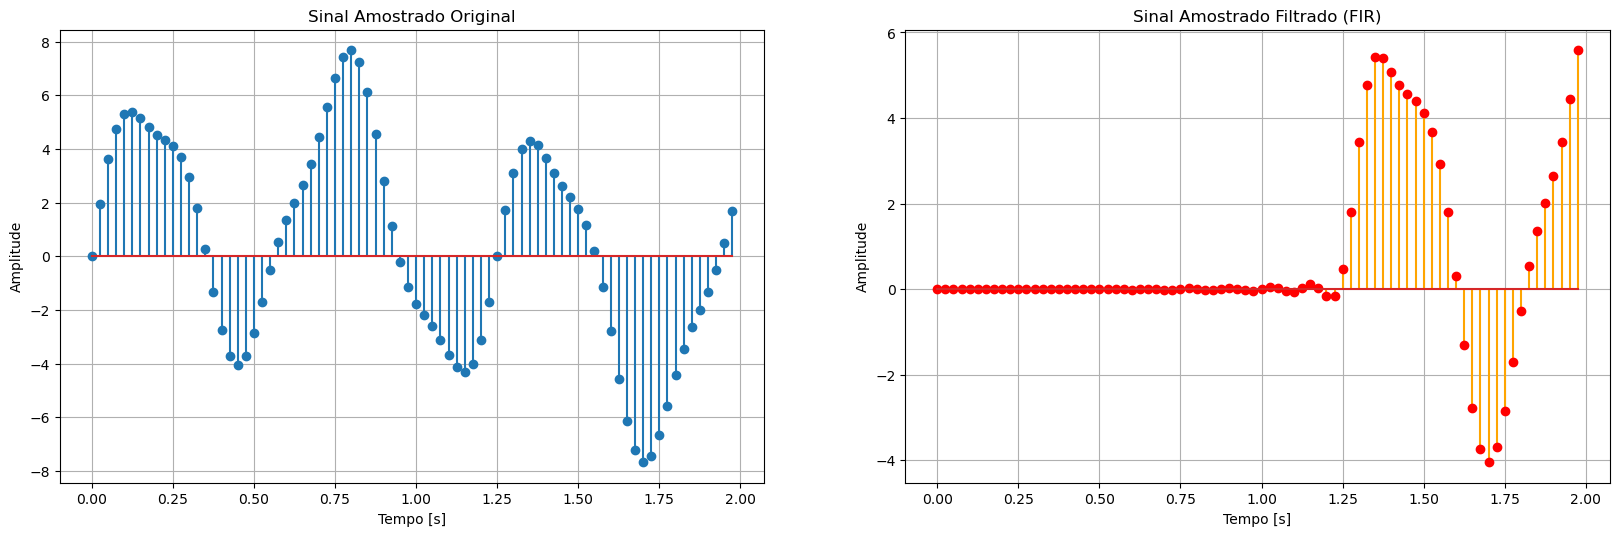

In [11]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 3)
plt.stem(t_amostrado, ruido_amostrado, label='Original')
plt.title('Sinal Amostrado Original')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.stem(t_amostrado, sinal_filtrado_amostrado, label='Filtrado', linefmt='orange', markerfmt='ro')
plt.title('Sinal Amostrado Filtrado (FIR)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

## Sinal Interpolado antes e depois do Filtro FIR:

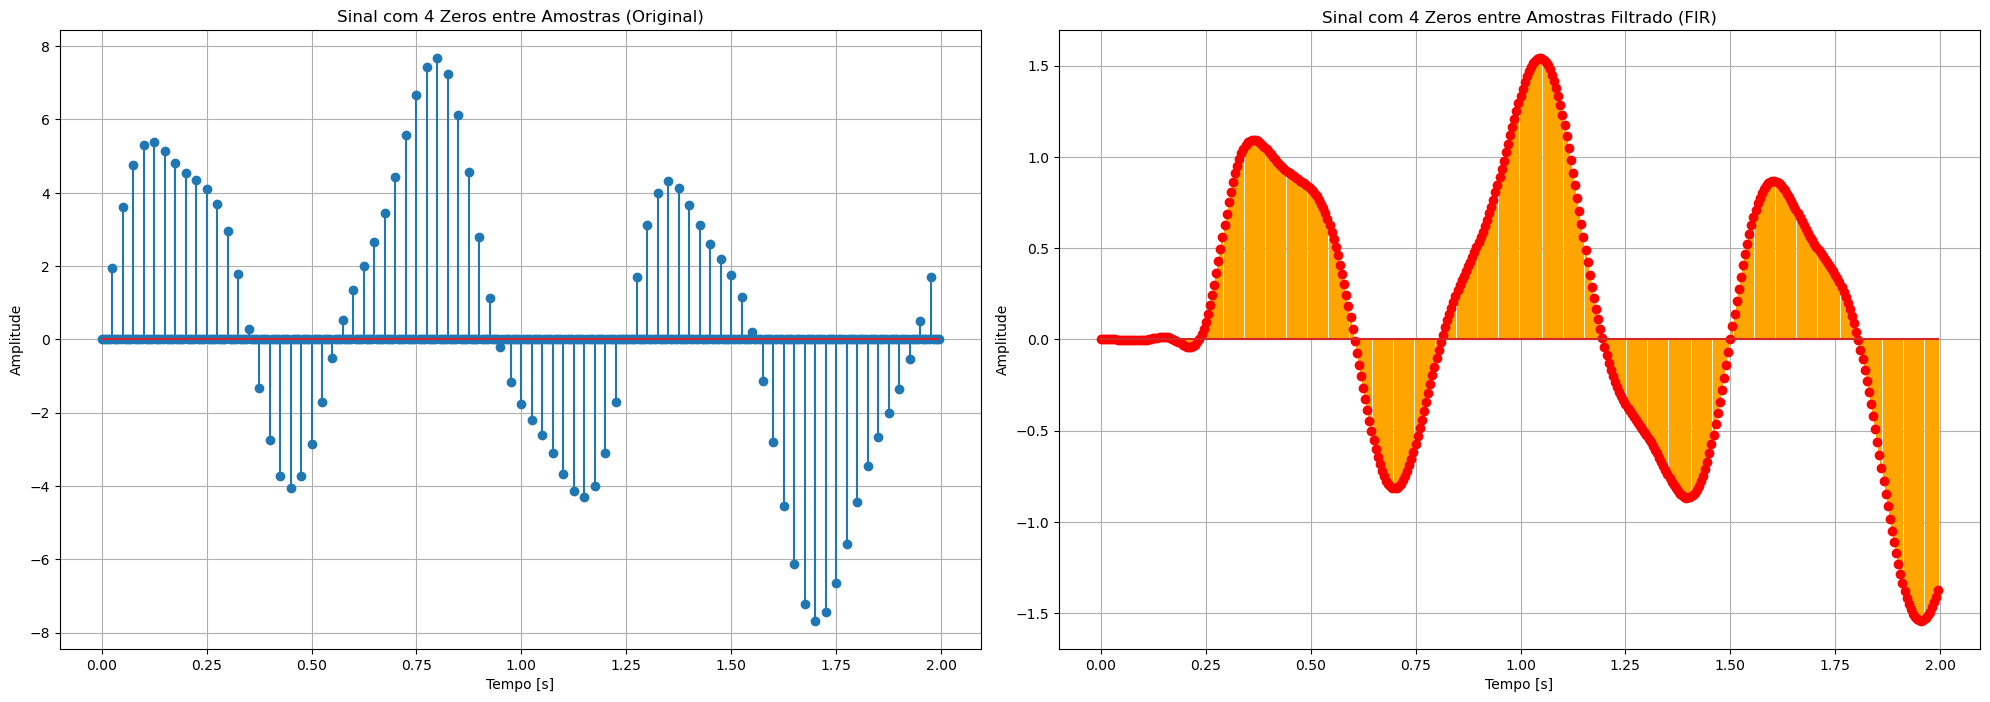

In [13]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 5)
plt.stem(t_decimado, ruido_decimado, label='Original')
plt.title(f'Sinal com {L} Zeros entre Amostras (Original)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.stem(t_decimado, sinal_filtrado_decimado, label='Filtrado', linefmt='orange', markerfmt='ro')
plt.title(f'Sinal com {L} Zeros entre Amostras Filtrado (FIR)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


<h4>
    O processo de filtragem do sinal interpolado acima não é otimizado, pois suas amostragem de amplitude zero entram no processo de multiplicação na filtragem, mas elas não trazem contribuição alguma para a informação do sinal
</h4>
<h4>
    Em um processomelhorado de interpolação de sinal com filtros polifásicos, essas multiplicações por zero são eliminadas, diminuindo assim o uso de CPU. Um filtro polifásico é formado por uma sequência de filtros FIR a depender de do fator de interpolação do sinal.
</h4>

<h4>
    Considade que o bloco abaixo descreve um filtro FIR de K taps tenho um sinal x[n] qualquer como entrada:
</h4>
<br/>
<br/>
<img src="FIR.png" style="display: block; margin: 0 auto; width: 340px;" />
<br/>
<br/>
<h4>
    Caso eu queria fazer uma interpolação por um fator L = 4 e 12 taps, por exemplo, basta fazer um banco com 4 filtros FIR e distribuir as taps entre eles, tendo então:
</h4>
<br/>
<br/>
<img src="polyphase_diagram.png" style="display: block; margin: 0 auto; width: 340px;" />
<br/>
<br/>
<h4>
    Uma outra forma é ter apenas um filtro FIR e comutar a entrada dos coeficientes, de forma que:
</h4>
<br/>
<br/>
<img src="commutated.png" style="display: block; margin: 0 auto; width: 400px;" />
<br/>
<br/>


## Implementando o filtro polifásico para interpolação:

In [16]:
def polyphase_filter(unsampled_signal, num_taps, cutoff, M):

    if num_taps % M != 0:
        num_taps += (M - num_taps % M)  

    h = signal.firwin(num_taps, cutoff)

    h_poly = np.zeros((M, num_taps // M))
    for i in range(M):
        h_poly[i] = h[i::M]

    upsampled_length = len(unsampled_signal) * M
    upsampled_signal = np.zeros(upsampled_length)
    upsampled_signal[::M] = unsampled_signal

    output_signal = np.zeros(upsampled_length)

    for i in range(M):
        phase_signal = signal.lfilter(h_poly[i], 1, upsampled_signal)
        output_signal += np.roll(phase_signal, i) 

    return output_signal


## Plotando o Sinal de saída do filtro polifásico

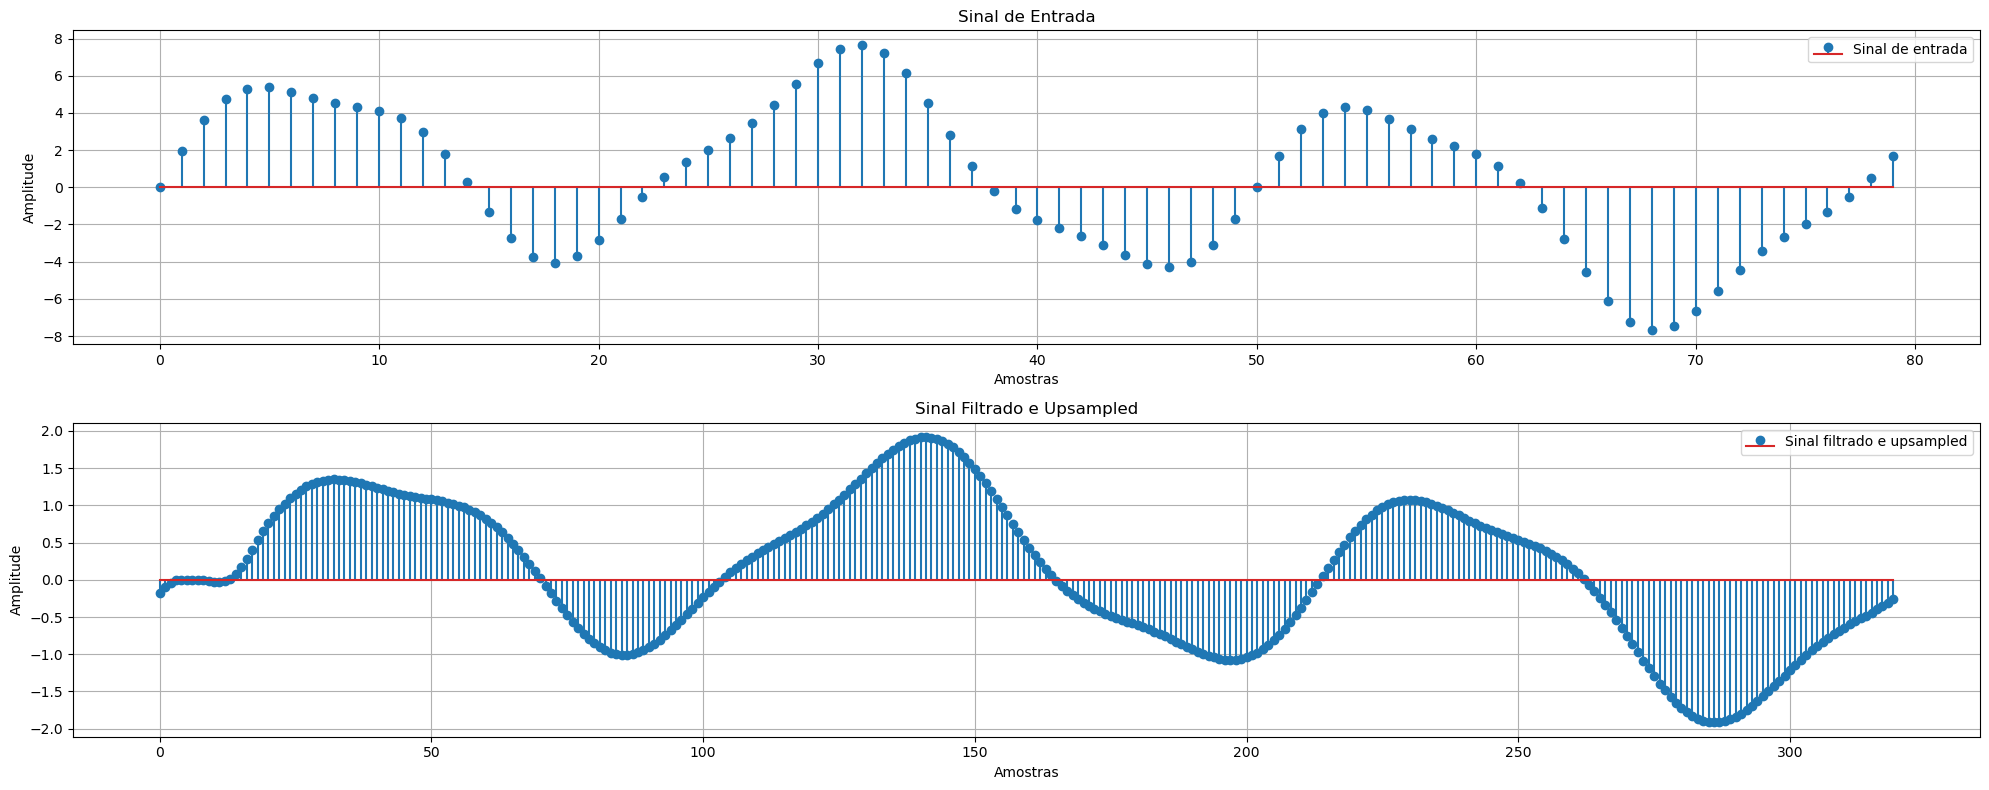

In [18]:
polyphasefilter_signal = polyphase_filter(ruido_amostrado, 100, (frequencia/(L*20)), L)

plt.figure(figsize=(20, 8))

# Gráfico do sinal de entrada
plt.subplot(2, 1, 1)
plt.stem(ruido_amostrado, label='Sinal de entrada')
plt.title('Sinal de Entrada')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.grid()

plt.legend()

# Gráfico do sinal filtrado
plt.subplot(2, 1, 2)
plt.stem(polyphasefilter_signal, label='Sinal filtrado e upsampled')
plt.title('Sinal Filtrado e Upsampled')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
